In [1]:
#NN Surrogate model class
from injector_surrogate_quads import *
import physics_gp

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import gpytorch
import botorch 

import matplotlib.pyplot as plt

# BO for Minimizing Emittance*Bmag with 9 Variables (SQ, CQ, SOL, matching quads)

In [2]:
#load injector model
# Model = Surrogate_NN()

# Model.load_saved_model(model_path = '../models/', \
#                        model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
# Model.load_scaling()
# Model.take_log_out = False
Model = Surrogate_NN(pytorch=True)

Model.load_saved_model(model_path = '../models/', 
                       model_name = 'Surrogate_NN_PyTorch')

Model.load_scaling(scalerfilex = '../data/transformer_x_pytorch.pth', 
                   scalerfiley = '../data/transformer_y_pytorch.pth')
Model.take_log_out = False

## Import design Twiss parameters (OTR2)

In [3]:
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
print(twiss0['x'])
print(twiss0['y'])

[1e-06, 1.113081026, -0.0689403587]
[1e-06, 1.113021659, -0.07029489754]


## Objective Function

In [4]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

In [5]:
def evaluate(config): 
    """
    D is input space dimensionality
    N is number of sample points
    :param config: input values of opt_var_names, torch.tensor, shape (N, D) 
    returns (1, N) 
    """
    N = config.shape[0]
    D = config.shape[1]
    
    # make input array of length model_in_list (inputs model takes)
    x_in = torch.empty((N,len(Model.model_in_list)))
    
    # fill in reference point around which to optimize
    x_in[:,:] = torch.tensor(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    col = []
    for i in range(D):
        col.append(Model.loc_in[opt_var_names[i]]) #should make col a flat list of indices, e.g. [4, 6, 7]
    x_in[:, col] = config[:,:] 
    
    #output predictions
    y_out = Model.pred_machine_units(x_in)

    return -1*objective(y_out) ## detach issue 


def objective(y_out):
    """
    y_out has a shape of (M, N, num_outputs)
    """
    # output is emittance * bmag 
    
    # geometric emittance in transverse plane
    out1 = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = torch.sqrt(out1 * out2)
  
    sigma_x = y_out[:,Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:,Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x = torch.tensor(alpha0_x).repeat(y_out.shape[0])
    alpha_y = torch.tensor(alpha0_y).repeat(y_out.shape[0])
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * torch.sqrt(beta0_x / beta_x) - alpha0_x * torch.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * torch.sqrt(beta0_y / beta_y) - alpha0_y * torch.sqrt(beta_y / beta0_y))**2)
    bmag = torch.sqrt(bmag_x * bmag_y)
    #print(f'bmag: {bmag} emit: {emit}') 
    
    return (emit * bmag)/1e-6 # in um units 
    #return np.sqrt(out1*out2)/1e-6 # in um units

## Set up initial training samples

In [6]:
#create initial samples within specified bounds
n_samples = 3
n_var = 9

train_x = torch.zeros((n_samples, n_var)) 
for i in range(n_var):
    train_x[:,i] = torch.tensor(np.random.uniform(bounds[i,0],bounds[i,1],(n_samples,)))
print(train_x)

train_y = evaluate(train_x).detach().reshape(-1,1) # detach gradient to fix going backwards twice error while fitting hyperparameters
print(train_y)

tensor([[ 0.4781,  0.0188, -0.0087, -2.6889,  1.1584, -5.1490,  6.1537,  0.9943,
         -4.4428],
        [ 0.4841,  0.0115,  0.0152, -1.6708,  2.8395, -2.9100,  2.8888,  2.8933,
         -2.5482],
        [ 0.4838,  0.0154, -0.0117, -2.0354,  3.5874, -1.8302,  2.3025, -0.2724,
         -5.2026]])
tensor([[-3.9330],
        [-1.6589],
        [-3.3186]])


## Bayesian Optimization

### Gaussian Regression & Acquisition Function

In [7]:
def get_BO_point(x, f, bounds, beta=0.1, mean_module=None, input_transform=None, outcome_transform=None):
    """
    function that trains a GP model of data and returns the next observation point using UCB
    D is input space dimensionality
    N is number of samples

    :param x: input points data, torch.tensor, shape (N,D)
    :param f: output point data, torch.tensor, shape (N,1)
    :param bounds: input space bounds, torch.tensor, shape (2,D)
    :param precision: precision matrix used for RBF kernel (must be PSD), torch.tensor, (D,D)
    :param beta: UCB optimization parameter, float
    :return x_candidate, model: next observation point and gp model w/observations
    """
    gp = botorch.models.SingleTaskGP(x, f,
                                     mean_module=mean_module, 
                                     outcome_transform=outcome_transform, 
                                     input_transform=input_transform)
        
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    
    # fit GP hyperparameters
    botorch.fit.fit_gpytorch_model(mll)

    # do UCB acquisition
    UCB = botorch.acquisition.UpperConfidenceBound(gp, beta=beta)
    candidate, acq_value = botorch.optim.optimize_acqf(UCB,
                                                       bounds=bounds,
                                                       q=1,
                                                       num_restarts=100,
                                                       raw_samples=100)
    return candidate, gp

In [8]:
def BayesianOptimization(train_x, train_y, n_steps, prior=None, transformer_x=None, transformer_y=None):
    best_y_list = []
    best_y = torch.max(train_y)
    best_y_list.append(best_y)
    
    for i in range(n_steps):
        x_new, model = get_BO_point(train_x, train_y, 
                                    bounds=bounds.transpose(0,1), 
                                    mean_module=prior, 
                                    input_transform=transformer_x, 
                                    outcome_transform=transformer_y)

        train_x = torch.cat((train_x, x_new))
        new_y = evaluate(train_x[-1].reshape(1,-1)).detach().reshape(1,1)
        train_y = torch.cat((train_y, new_y))

        if (new_y > best_y):
            best_y = new_y
            color = '\033[95m', '\033[0m'
        else: 
            color = '\u001b[30m', '\033[0m'
        
        best_y_list.append(best_y)
        
#         print("iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4")
#         print(f'{color[0]}{i+1}      {train_y[-1,0]:.5f}   {train_x[-1,0]:.5f}   {train_x[-1,1]:.5f}   {train_x[-1,2]:.5f}   {train_x[-1,3]:.5f}   {train_x[-1,4]:.5f}   {train_x[-1,5]:.5f}   {train_x[-1,6]:.5f}   {train_x[-1,7]:.5f}   {train_x[-1,8]:.5f}{color[1]}')
        
    return torch.tensor(best_y_list), train_x

In [9]:
# # constant prior mean
# constant_prior_best_y = BayesianOptimization(train_x, train_y, 30, prior = None) 

### use NN as prior mean

In [10]:
# model 
import torch.nn as nn
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 20
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 

# create prior mean
from gpytorch.means.mean import Mean
class CustomMean(Mean):
    def __init__(self, name, y_norm_transform, outcome_transform):
        super(CustomMean, self).__init__()
        self.NN_model = NN_prior()
        self.NN_model.load_state_dict(torch.load('./results/' + name + '.pth'))
        self.NN_model.eval()
        
        self.y_norm_transform = y_norm_transform
        self.outcome_transform = outcome_transform
        
    def forward(self, x):
        """
        takes in transformed x, returns transformed y
        """
        self.outcome_transform.eval()
        
        m = self.NN_model(x) # normed x |-> NN normed y 
        m = self.y_norm_transform.untransform(m) # NN normed y -> real y
        m = self.outcome_transform(m)[0] # real y -> standardized y
        self.outcome_transform.train()
        return m.squeeze()
    
# surrogate model
class Surrogate(Mean):
    def __init__(self, input_transform, outcome_transform):
        super(Surrogate, self).__init__()
        self.input_transform = input_transform 
        self.outcome_transform = outcome_transform

    def forward(self, x):
        """
        takes in transformed x, returns transformed y
        """
        self.input_transform.eval()
        self.outcome_transform.eval()
        
        x = self.input_transform.untransform(x) # normed x -> real x 
        #print(x)
        out = []
        
        # reshape x into (batch_size, n_samples, n_var) if necessary 
        if (x.dim() == 2):
            x = x.unsqueeze(dim=0)
        for i in range(x.size(dim=0)):
            m = evaluate(x[i].detach()).float() # real x |-> real y
            m = self.outcome_transform(m)[0] # real y -> standardized y
            out.append(m.squeeze())
            
        self.input_transform.eval() 
        self.outcome_transform.train()
        return torch.stack(out,dim=0)

In [11]:
NN_transformer_y = botorch.models.transforms.input.Normalize(1)
NN_transformer_y.load_state_dict(torch.load('./results/transformer_y_norm.pth'))
NN_transformer_y.eval() 
        
#print(NN_prior_mean)

# NN_prior_best_y = BayesianOptimization(train_x, 
#                                        train_y, 
#                                        n_steps=30, 
#                                        prior=CustomMean('model_1hidden_20nodes_500epoch_0.02', NN_transformer_y, transformer_y))

Normalize()

In [12]:
transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
surrogate_list = []
NN_list = []
const_list = []

plt.gcf().set_size_inches(15,35)

n_trials = 1
n_steps = 30
for i in range(n_trials):
    # samples
    train_x = torch.zeros((n_samples, n_var)) 
    for j in range(n_var):
        train_x[:,j] = torch.tensor(np.random.uniform(bounds[j,0],bounds[j,1],(n_samples,)))
    # print(train_x) 

    train_y = evaluate(train_x).detach().reshape(-1,1)
    # print(train_y)
    
    # run both normal and expressive prior BO 
    print(f'iter {i}')
    print("1")
    transformer_y = botorch.models.transforms.outcome.Standardize(1)
    const_prior_best_y, const_x_config = BayesianOptimization(train_x, 
                                                 train_y, 
                                                 n_steps=n_steps, 
                                                 prior=None, 
                                                 transformer_x=transformer_x,
                                                 transformer_y=transformer_y)
    
#     print("2")
#     transformer_y = botorch.models.transforms.outcome.Standardize(1)
#     NN_prior_best_y, NN_x_config = BayesianOptimization(train_x, 
#                                            train_y, 
#                                            n_steps=n_steps, 
#                                            prior=CustomMean('model_1hidden_20nodes_500epoch_0.02', NN_transformer_y, transformer_y),
#                                            transformer_x=transformer_x,
#                                            transformer_y=transformer_y)
    
    print("3")
    transformer_y = botorch.models.transforms.outcome.Standardize(1)
    surrogate_prior_best_y, surrogate_x_config = BayesianOptimization(train_x,
                                                  train_y,
                                                  n_steps=n_steps,
                                                  prior=Surrogate(transformer_x, transformer_y), 
                                                  transformer_x=transformer_x,
                                                  transformer_y=transformer_y)
    
    surrogate_list.append(surrogate_prior_best_y)
    # NN_list.append(NN_prior_best_y)
    const_list.append(const_prior_best_y) 
    # plot best_y trends across iterations 
    # plt.subplot(10,2,i+1)
    # plt.xlabel('iter')
    # plt.ylabel('best y')
    # plt.plot(const_prior_best_y, label = "constant")
    # plt.plot(NN_prior_best_y, label = "NN")
    # plt.legend()


iter 0
1
3


<Figure size 1080x2520 with 0 Axes>

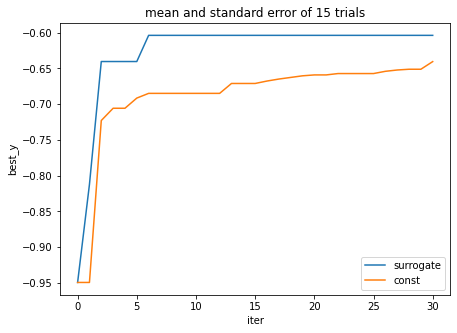

In [13]:
# plot best_y mean and std  

# NN_best = torch.stack(NN_list, dim=0)
surrogate_best = torch.stack(surrogate_list, dim=0)
const_best = torch.stack(const_list, dim=0)

# NN_mean = torch.mean(NN_best, dim=0).detach()
# NN_std = torch.std(NN_best, dim=0).detach() / np.sqrt(torch.tensor(n_trials))

surrogate_mean = torch.mean(surrogate_best, dim=0).detach()
surrogate_std = torch.std(surrogate_best, dim=0).detach() / np.sqrt(torch.tensor(n_trials))

const_mean = torch.mean(const_best, dim=0).detach()
const_std = torch.std(const_best, dim=0).detach() / torch.sqrt(torch.tensor(n_trials))

fig,ax = plt.subplots()
# # plotting
# #for b in best:
# #    ax.plot(x, b.detach(), color, alpha=0.25)

ax.set_title('mean and standard error of 15 trials')
x = torch.arange(len(const_mean))
ax.set_xlabel('iter')
ax.set_ylabel('best_y')
# ax.plot(x, NN_mean,label="NN")
# ax.fill_between(x, NN_mean - 2*NN_std, NN_mean + 2*NN_std, alpha=0.25)

ax.plot(x, surrogate_mean,label="surrogate")
ax.fill_between(x, surrogate_mean - 2*surrogate_std, surrogate_mean + 2*surrogate_std, alpha=0.25)

ax.plot(x, const_mean,label="const")
ax.fill_between(x, const_mean - 2*const_std, const_mean + 2*const_std, alpha=0.25)

fig.set_size_inches(7, 5)
plt.legend(loc='lower right')

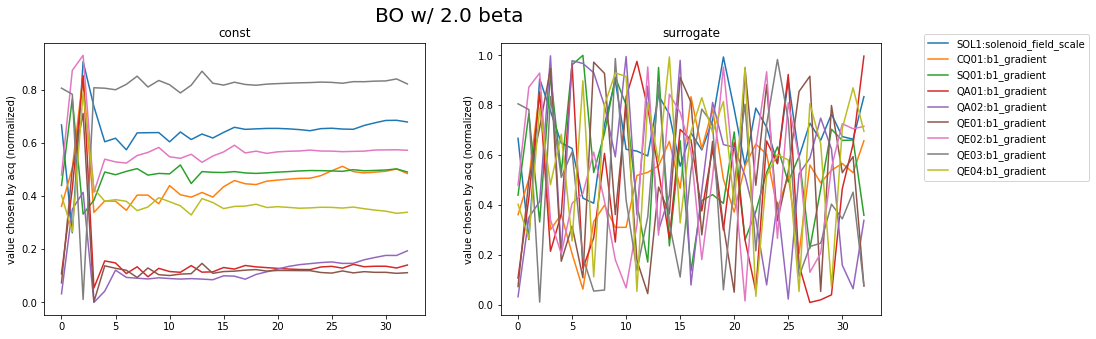

In [14]:
# plot variable changes per iteration 
# fig,ax = plt.subplots()
# # plotting
# #for b in best:
# #    ax.plot(x, b.detach(), color, alpha=0.25)
# fig.set_size_inches(7, 5)
# plt.legend()

normed_const_x_config = transformer_x(const_x_config)
normed_surrogate_x_config = transformer_x(surrogate_x_config) 
# normed_NN_x_config = transformer_x(NN_x_config) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('BO w/ 2.0 beta', fontsize=20)
fig.set_size_inches(15, 5)
for i in range(len(opt_var_names)):
    ax1.set_title('const')
    ax1.set_ylabel('value chosen by acq (normalized)')
    ax1.plot(normed_const_x_config[:,i], label = opt_var_names[i])
    ax2.set_title('surrogate')
    ax2.set_ylabel('value chosen by acq (normalized)')
    ax2.plot(normed_surrogate_x_config[:,i], label = opt_var_names[i])

ax2.legend(bbox_to_anchor=(1.1, 1.05))

In [15]:
"""
#define acquisition function
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

#optimize
n_steps = 45
for i in range(n_steps):
    #best_normed_y = torch.max(normed_train_y)
    UCB = UpperConfidenceBound(gp, beta=2.5)
    #EI = ExpectedImprovement(gp, best_normed_y)

    bounds = torch.cat((torch.zeros(1,3), torch.ones(1,3)), 0)
    candidate, acq_value = optimize_acqf(UCB, bounds = bounds, num_restarts = 20, q = 1, raw_samples = 20)

    train_x = torch.cat((train_x, transformer_x.backward(candidate)))
    normed_train_x = transformer_x.forward(train_x)

    new_y = torch.tensor(evaluate(train_x[-1][0], train_x[-1][1], train_x[-1][2])).reshape(1,1)
    train_y = torch.cat((train_y, new_y))
    
    print("iteration        target         varx         vary         varz")
    print(f'{i+1}              {train_y[-1][0]:.5f}      {train_x[-1][0]:.5f}      {train_x[-1][1]:.5f}      {train_x[-1][2]:.5f}')
    print(torch.max(train_y))
    
    transformer_y = transformer.Transformer(train_y, 'standardize')
    normed_train_y = transformer_y.forward(train_y)

    gp = SingleTaskGP(normed_train_x, normed_train_y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll);
"""

'\n#define acquisition function\nfrom botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement\nfrom botorch.optim import optimize_acqf\n\n#optimize\nn_steps = 45\nfor i in range(n_steps):\n    #best_normed_y = torch.max(normed_train_y)\n    UCB = UpperConfidenceBound(gp, beta=2.5)\n    #EI = ExpectedImprovement(gp, best_normed_y)\n\n    bounds = torch.cat((torch.zeros(1,3), torch.ones(1,3)), 0)\n    candidate, acq_value = optimize_acqf(UCB, bounds = bounds, num_restarts = 20, q = 1, raw_samples = 20)\n\n    train_x = torch.cat((train_x, transformer_x.backward(candidate)))\n    normed_train_x = transformer_x.forward(train_x)\n\n    new_y = torch.tensor(evaluate(train_x[-1][0], train_x[-1][1], train_x[-1][2])).reshape(1,1)\n    train_y = torch.cat((train_y, new_y))\n    \n    print("iteration        target         varx         vary         varz")\n    print(f\'{i+1}              {train_y[-1][0]:.5f}      {train_x[-1][0]:.5f}      {train_x[-1][1]:.5f}      {train_x[-